In [1]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *

In [2]:
p = MPS_rand_state(n=20, bond_dim=50)
print(f"Site tags: '{p.site_tag_id}', site inds: '{p.site_ind_id}'")

Site tags: 'I{}', site inds: 'k{}'


In [3]:
print(p)  # shows the full list of constituent tensors

MatrixProductState([
    Tensor(shape=(50, 2), inds=('_512c880000000', 'k0'), tags=('I0',)),
    Tensor(shape=(50, 50, 2), inds=('_512c880000000', '_512c880000002', 'k1'), tags=('I1',)),
    Tensor(shape=(50, 50, 2), inds=('_512c880000002', '_512c880000004', 'k2'), tags=('I2',)),
    Tensor(shape=(50, 50, 2), inds=('_512c880000004', '_512c880000006', 'k3'), tags=('I3',)),
    Tensor(shape=(50, 50, 2), inds=('_512c880000006', '_512c880000008', 'k4'), tags=('I4',)),
    Tensor(shape=(50, 50, 2), inds=('_512c880000008', '_512c88000000a', 'k5'), tags=('I5',)),
    Tensor(shape=(50, 50, 2), inds=('_512c88000000a', '_512c88000000c', 'k6'), tags=('I6',)),
    Tensor(shape=(50, 50, 2), inds=('_512c88000000c', '_512c88000000e', 'k7'), tags=('I7',)),
    Tensor(shape=(50, 50, 2), inds=('_512c88000000e', '_512c88000000A', 'k8'), tags=('I8',)),
    Tensor(shape=(50, 50, 2), inds=('_512c88000000A', '_512c88000000C', 'k9'), tags=('I9',)),
    Tensor(shape=(50, 50, 2), inds=('_512c88000000C', '_512c8

In [4]:
p.show()  # 1D tensor networks also have a ascii ``show`` method

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●
│  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │


We can then __canonicalize__ the MPS:

In [5]:
p.left_canonize()
p.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──●
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │


And we can compute the inner product as:

In [6]:
p.H @ p

1.0000000000000002

This relies on them sharing the same physical indices, ``site_ind_id``, 
which the conjugated copy ``p.H`` naturally does.

Like any TN, we can __graph__ the overlap for example, and make use of the 
site tags to color it:

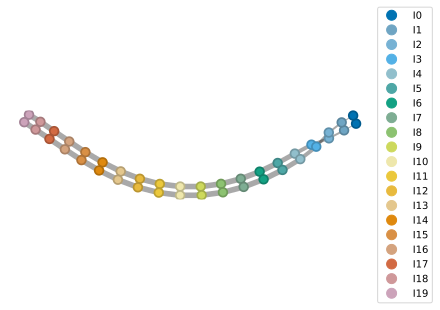

In [7]:
(p.H & p).graph(color=[f'I{i}' for i in range(20)])

In [8]:
p2 = (p + p) / 2
p2.show()

 4 8 16 32 64 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
●─●─●──●──●──●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●
│ │ │  │  │  │   │   │   │   │   │   │   │   │   │   │   │   │   │   │


Which doubles the bond dimension, as expected, but should still be normalized:

In [9]:
p2.H @ p2

0.9999999999999999

Because the MPS is the addition of two identical states, it should also __compress__ right back down:

In [10]:
p2.compress(form=10)
p2.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 32 16 8 4 2 
>─>─>─>──>──>──>──>──>──>──●──<──<──<──<──<──<─<─<─<
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │ │


Where we have also set the __orthogonality center__ at the site 10.

When tensor networks are imbued with a ``structure``, they 
can be indexed with integers and slices, which automatically get
converted using ``TN.site_tag_id``:

In [11]:
p2[10]  # get the tensor(s) with tag 'I10'.

Tensor(shape=(50, 50, 2), inds=('_512c88000000C', '_512c88000000E', 'k10'), tags=('I10',))

Note the tensor has matching physical index ``'k10'``.

This tensor is the orthogonality center so:

       ─>─>─●─<─<─        ╭─●─╮
    ... │ │ │ │ │ ...  =  │ │ │
       ─>─>─●─<─<─        ╰─●─╯
           i=10            i=10

should compute the normalization of the *whole* state:

In [12]:
p2[10].H @ p2[10]  # all indices match -> inner product

0.9999999999999983

Or equivalently:

In [13]:
p2[10].norm()

0.9999999999999991

If two tensor networks with the same ``structure`` are combined, it is propagated.
For example ``(p2.H & p2)`` can still be sliced.

Since the MPS is in canonical form, left and right pieces of the overlap
should form the identity. The following forms a TN of the inner product, 
selects the *2* tensors corresponding to the last site (``-1``), contracts them, 
then gets the underlying data:

In [14]:
((p2.H & p2).select(-1) ^ all).data.round(12)  # should be close to the identity

array([[ 1., -0.],
       [-0.,  1.]])

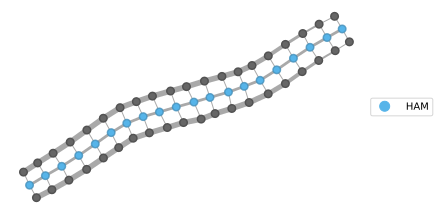

In [15]:
A = MPO_rand_herm(20, bond_dim=7, tags=['HAM'])
pH = p.H

# This inplace modifies the indices of each to form overlap
p.align_(A, pH)

(pH & A & p).graph(color='HAM', iterations=20, initial_layout='kamada_kawai')

Compute the actual contraction (``...`` means contract everything, but use the structure if possible):

In [16]:
(pH & A & p) ^ ...

-3.9840952121346357e-07

In [17]:
builder = SpinHam(S=1)
builder += 1/2, '+', '-'
builder += 1/2, '-', '+'
builder += 1, 'Z', 'Z'
H = builder.build_mpo(n=100)

In [18]:
dmrg = DMRG2(H, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

The ``DMRG`` object will automatically detect OBC/PBC. Now we can solve to a certain absolute energy tolerance, showing progress and a schematic of the final state:

In [19]:
dmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|##########################################| 99/99 [00:00<00:00, 126.66it/s]

Energy: -138.73624288100052 ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-10



100%|##########################################| 99/99 [00:00<00:00, 252.21it/s]

Energy: -138.93683254273122 ... not converged.
SWEEP-3, direction=R, max_bond=(20/100), cutoff:1e-10



100%|##########################################| 99/99 [00:00<00:00, 132.43it/s]

Energy: -138.94004723038387 ... not converged.
SWEEP-4, direction=R, max_bond=(57/100), cutoff:1e-10



100%|###########################################| 99/99 [00:02<00:00, 41.44it/s]

Energy: -138.94008552029092 ... not converged.
SWEEP-5, direction=R, max_bond=(91/200), cutoff:1e-10



100%|###########################################| 99/99 [00:03<00:00, 27.41it/s]

Energy: -138.94008604521198 ... converged!


True

In [20]:
dmrg.state.show(max_width=80)

     3 9 27 53 65 74 79 83 87 91 93 94 93 94 95 95 95 95 94 93 93 93 92 92    
... >─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>── ...
    │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │      
                                 ...                                  
     91 91 91 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90     
... >──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──> ...
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │    
                                 ...                                  
    90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 9    
... ──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>─ ...
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │     
                                 ...                                  
    0 90 90 90 90 91 93 94 94 95 95 96 96 97 97 97 96 94 93 90 87 83 78 73  

In [21]:
builder = SpinHam(S=1 / 2)
builder.add_term(1.0, 'Z', 'Z')
builder.add_term(0.9, 'Y', 'Y')
builder.add_term(0.8, 'X', 'X')
builder.add_term(0.6, 'Z')

H = NNI_ham_heis(20, bz=0.1)

# check the two site term
H()

[[ 0.2  0.   0.   0. ]
 [ 0.  -0.3  0.5  0. ]
 [ 0.   0.5 -0.2  0. ]
 [ 0.   0.   0.   0.3]]

In [22]:
psi0 = MPS_neel_state(20)
tebd = TEBD(psi0, H)

Now we are ready to evolve. By setting a ``tol``, the required timestep ``dt`` is computed for us:

In [23]:
tebd.update_to(T=3, tol=1e-3)

t=3, max-bond=34: 100%|##########| 100/100 [00:01<00:00, 66.58%/s]   


After the evolution we can see that entanglement has been generated throughout the chain:

In [24]:
tebd.pt.show()

 2 4 8 16 29 34 33 34 33 34 33 34 33 34 29 16 8 4 2 
>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>─>─>─●
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │ │


In [25]:
import quimb as qu
Z = qu.pauli('Z')

# compute <psi0|Z_i|psi0> for neel state above
[
    psi0.gate(Z, i).H @ psi0 
    for i in range(10)
]

[(1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j)]

In [26]:
import quimb as qu

# some operators to apply
H = qu.hadamard()
CNOT = qu.controlled('not')

# setup an intitial register of qubits
n = 10
psi0 = MPS_computational_state('0' * n, tags='PSI0')

# apply hadamard to each site
for i in range(n):
    psi0.gate_(H, i, tags='H')
    
# apply CNOT to even pairs
for i in range(0, n, 2):
    psi0.gate_(CNOT, (i, i + 1), tags='CNOT')
    
# apply CNOT to odd pairs
for i in range(1, n - 1, 2):
    psi0.gate_(CNOT, (i, i + 1), tags='CNOT')

Note we have used the inplace ``gate_`` (with a trailing
underscore) which modifies the original ``psi0`` object.
However ``psi0`` has its physical site indices mantained
such that it overall looks like the same object:

In [27]:
sorted(psi0.outer_inds())

['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9']

In [28]:
(psi0.H & psi0) ^ all

(0.9999999999999978+0j)

But the network now contains the gates as additional tensors:

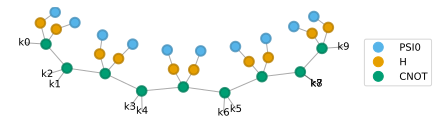

In [29]:
psi0.graph(color=['PSI0', 'H', 'CNOT'], show_inds=True)

With the swap and split method MPS form is always maintained, which
allows a canonical form and thus optimal trimming of singular values:

In [30]:
n = 10
psi0 = MPS_computational_state('0' * n)

for i in range(n):
    # 'swap+split' will be ignore to one-site gates
    psi0.gate_(H, i, contract='swap+split')
    
# use Z-phase to create entanglement
Rz = qu.phase_gate(0.42)
for i in range(n):
    psi0.gate_(Rz, i, contract='swap+split')
    
for i in range(0, n, 2):
    psi0.gate_(CNOT, (i, i + 1), contract='swap+split')
    
for i in range(1, n - 1, 2):
    psi0.gate_(CNOT, (i, i + 1), contract='swap+split')
    
# act with one long-range CNOT
psi0.gate_(CNOT, (2, n - 2), contract='swap+split')

<MatrixProductState(tensors=10, indices=19, structure='I{}', nsites=10)>

We now still have an MPS, but with increased bond dimension:

In [31]:
psi0.show()

 2 2 4 4 4 4 4 2 2 
>─>─>─>─>─>─>─●─●─<
│ │ │ │ │ │ │ │ │ │


Finally, the eager (``contract=True``) method works fairly simply:

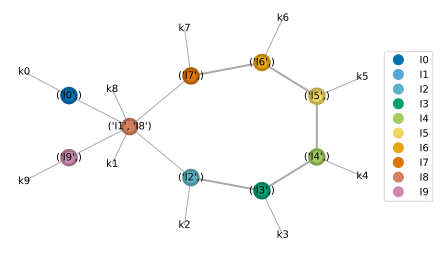

In [32]:
psi0_CNOT = psi0.gate(CNOT, (1, n -2 ), contract=True)
psi0_CNOT.graph(color=[psi0.site_tag(i) for i in range(n)])